### Von-Mises-Fischer dist functions

In [4]:
%cd ..

/home/skholkin/projects/SS_DDPM


In [5]:
import numpy as np
from scipy.linalg import null_space
import numpy.matlib
import torch
import matplotlib.pyplot as plt
device = 'cpu'



# https://github.com/dlwhittenbury/von-Mises-Fisher-Sampling

def rand_uniform_hypersphere(N,p):
    
    """ 
        rand_uniform_hypersphere(N,p)
        =============================
    
        Generate random samples from the uniform distribution on the (p-1)-dimensional 
        hypersphere $\mathbb{S}^{p-1} \subset \mathbb{R}^{p}$. We use the method by 
        Muller [1], see also Ref. [2] for other methods.
        
        INPUT:  
        
            * N (int) - Number of samples 
            * p (int) - The dimension of the generated samples on the (p-1)-dimensional hypersphere.
                - p = 2 for the unit circle $\mathbb{S}^{1}$
                - p = 3 for the unit sphere $\mathbb{S}^{2}$
            Note that the (p-1)-dimensional hypersphere $\mathbb{S}^{p-1} \subset \mathbb{R}^{p}$ and the 
            samples are unit vectors in $\mathbb{R}^{p}$ that lie on the sphere $\mathbb{S}^{p-1}$.
    
    References:
    
    [1] Muller, M. E. "A Note on a Method for Generating Points Uniformly on N-Dimensional Spheres."
    Comm. Assoc. Comput. Mach. 2, 19-20, Apr. 1959.
    
    [2] https://mathworld.wolfram.com/SpherePointPicking.html
    
    """
    
    if (p<=0) or (type(p) is not int):
        raise Exception("p must be a positive integer.")
    
    # Check N>0 and is an int
    if (N<=0) or (type(N) is not int):
        raise Exception("N must be a non-zero positive integer.")
    
    v = np.random.normal(0,1,(N,p))
        
    v = np.divide(v,np.linalg.norm(v,axis=1,keepdims=True))
    
    return v

def rand_t_marginal(kappa,p,N=1):
    """
        rand_t_marginal(kappa,p,N=1)
        ============================
        
        Samples the marginal distribution of t using rejection sampling of Wood [3]. 
    
        INPUT: 
        
            * kappa (float) - concentration        
            * p (int) - The dimension of the generated samples on the (p-1)-dimensional hypersphere.
                - p = 2 for the unit circle $\mathbb{S}^{1}$
                - p = 3 for the unit sphere $\mathbb{S}^{2}$
            Note that the (p-1)-dimensional hypersphere $\mathbb{S}^{p-1} \subset \mathbb{R}^{p}$ and the 
            samples are unit vectors in $\mathbb{R}^{p}$ that lie on the sphere $\mathbb{S}^{p-1}$.
            * N (int) - number of samples 
        
        OUTPUT: 
        
            * samples (array of floats of shape (N,1)) - samples of the marginal distribution of t
    """
    
    # Check kappa >= 0 is numeric 
    if (kappa < 0) or ((type(kappa) is not float) and (type(kappa) is not int)):
        raise Exception("kappa must be a non-negative number.")
        
    if (p<=0) or (type(p) is not int):
        raise Exception("p must be a positive integer.")
    
    # Check N>0 and is an int
    if (N<=0) or (type(N) is not int):
        raise Exception("N must be a non-zero positive integer.")
    
    
    # Start of algorithm 
    b = (p - 1.0) / (2.0 * kappa + np.sqrt(4.0 * kappa**2 + (p - 1.0)**2 ))    
    x0 = (1.0 - b) / (1.0 + b)
    c = kappa * x0 + (p - 1.0) * np.log(1.0 - x0**2)
    
    samples = np.zeros((N,1))
    
    # Loop over number of samples 
    for i in range(N):
        
        # Continue unil you have an acceptable sample 
        while True: 
            
            # Sample Beta distribution
            Z = np.random.beta( (p - 1.0)/2.0, (p - 1.0)/2.0 )
            
            # Sample Uniform distribution
            U = np.random.uniform(low=0.0,high=1.0)
            
            # W is essentially t
            W = (1.0 - (1.0 + b) * Z) / (1.0 - (1.0 - b) * Z)
            
            # Check whether to accept or reject 
            if kappa * W + (p - 1.0)*np.log(1.0 - x0*W) - c >= np.log(U):
                
                # Accept sample
                samples[i] = W
                break
    
    return samples
                
def rand_von_mises_fisher(mu,kappa,N=1):
    """
        rand_von_mises_fisher(mu,kappa,N=1)
        ===================================
        
        Samples the von Mises-Fisher distribution with mean direction mu and concentration kappa. 
        
        INPUT: 
        
            * mu (array of floats of shape (p,1)) - mean direction. This should be a unit vector.
            * kappa (float) - concentration. 
            * N (int) - Number of samples. 
        
        OUTPUT: 
        
            * samples (array of floats of shape (N,p)) - samples of the von Mises-Fisher distribution
            with mean direction mu and concentration kappa. 
    """
    
    
    # Check that mu is a unit vector
    eps = 10**(-5) # Precision 
    norm_mu = np.linalg.norm(mu)
    if abs(norm_mu - 1.0) > eps:
        print(abs(norm_mu - 1.0))
        raise Exception("mu must be a unit vector.")
        
    # Check kappa >= 0 is numeric 
    if (kappa < 0) or ((type(kappa) is not float) and (type(kappa) is not int)):
        raise Exception("kappa must be a non-negative number.")
    
    # Check N>0 and is an int
    if (N<=0) or (type(N) is not int):
        raise Exception("N must be a non-zero positive integer.")
    
    # Dimension p
    p = len(mu)
    
    # Make sure that mu has a shape of px1
    mu = np.reshape(mu,(p,1))
    
    # Array to store samples 
    samples = np.zeros((N,p))
    
    #  Component in the direction of mu (Nx1)
    t = rand_t_marginal(kappa,p,N) 
    
    # Component orthogonal to mu (Nx(p-1))
    xi = rand_uniform_hypersphere(N,p-1) 
    
    # von-Mises-Fisher samples Nxp
    
    # Component in the direction of mu (Nx1).
    # Note that here we are choosing an 
    # intermediate mu = [1, 0, 0, 0, ..., 0] later
    # we rotate to the desired mu below
    samples[:,[0]] = t
    
    # Component orthogonal to mu (Nx(p-1))
    samples[:,1:] = np.matlib.repmat(np.sqrt(1 - t**2), 1, p-1) * xi
    
    # Rotation of samples to desired mu
    O = null_space(mu.T)
    R = np.concatenate((mu,O),axis=1)
    samples = np.dot(R,samples.T).T
    
    return samples

samples = rand_von_mises_fisher(np.array([0, 1, 0]), 1, N=100)
np.linalg.norm(samples, axis=1)


class BatchedvMF:
    def __init__(self, mu, kappa, device):
        self.mu = mu
        if not torch.allclose(torch.norm(mu, dim=1), torch.ones([mu.shape[0]]).to(device)):
            raise Exception("Mean is not on a sphere")
        self.kappa = kappa
        self.device = device

        
    def sample(self):
        batch_size = self.mu.shape[0]
        samples = []
        for i in range(batch_size):
            samples.append(rand_von_mises_fisher(np.array(self.mu[i].cpu()) / np.linalg.norm(self.mu[i].cpu()), float(self.kappa[i].cpu()), N=1))
            
        ret_val = torch.cat([torch.Tensor(item).unsqueeze(0) for item in samples], dim=0).to(self.device)
        return ret_val.squeeze()

dist = BatchedvMF(torch.Tensor([[0, 1, 0], [0, 1, 0]]).to(device), torch.Tensor([1, 0.5]).to(device), device='cpu')
samples = dist.sample()


In [6]:
from schedule import noising_sch
from functools import partial
from scipy.special import iv as I_bessel_fn
T = 100

noising_sch = partial(noising_sch, T=T)


def get_dist(k_t, x_0):
    dist = BatchedvMF(x_0, k_t, device=device)
    return dist
    
def KL(x_0, x_theta, t):
    k_t = noising_sch(t)
    k = 3
    return k_t * torch.Tensor(I_bessel_fn(k / 2, k_t.cpu().numpy()) / I_bessel_fn(k / 2 - 1, k_t.cpu().numpy())) * (x_0.T @ (x_0 - x_theta))
    
def KL(x_0, x_theta, t):
    # not exactly KL but loss function
    return torch.ones(t.shape[0]).to(device) - torch.diag(x_0 @ x_theta.T)
    
def sufficient_stats(x_t, t):
    k_t = noising_sch(t)
    return k_t * x_t
    

## Generate dataset

In [7]:
from tqdm import tqdm
batch_size = 64

def sample_chain_suff_stats_norm_alpha(t_batch, x_0):
    samples = []
    suff_stats = torch.zeros_like(x_0)
    suff_stats_normed = torch.zeros_like(x_0)
    t_min = torch.min(t_batch)
    helper = torch.Tensor([[t <= s for s in range(T + 1)] for t in t_batch]).to(device)
    
    alphas = torch.zeros_like(x_0)
    
    for s in range(T, int(t_min), -1):
        s_batch = torch.tensor([s], device=device).repeat(batch_size)
        helper_slice = helper[:, s]
        
        k_t = noising_sch(s_batch)
        
        dist = BatchedvMF(x_0, k_t, device=device)
        
        samples.append(dist.sample())
        alphas += helper_slice.reshape([-1, 1]) * k_t.reshape([-1, 1]).repeat([1, 1])
        
        suff_stats += helper_slice.reshape([-1, 1]) * sufficient_stats(samples[-1], s_batch.reshape([-1, 1]))
        
    suff_stats_normed = suff_stats / alphas
        
    return samples, suff_stats_normed

from utils import sample_t_batch
sample_t_batch = partial(sample_t_batch, T=T)


def generate_dataset(dataset, n_samples, batch_size=1024, save_path='generated_dataset.pth'):
    n_iters = n_samples // batch_size
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    x_0_storage = []
    t_batch_storage = []
    suff_stats_storage = []
    
    for i in tqdm(range(n_iters)):
        x_0 = next(iter(dataloader)).to(device)
        t_batch = sample_t_batch(batch_size)
        samples, suff_stats = sample_chain_suff_stats_norm_alpha(t_batch, x_0)
        
        x_0_storage.append(x_0.cpu())
        t_batch_storage.append(t_batch.cpu())
        suff_stats_storage.append(suff_stats.cpu())
        
    x_0_tensor = torch.cat(x_0_storage, dim=0)
    t_batch_tensor = torch.cat(t_batch_storage, dim=0)
    suff_stats_tensor = torch.cat(suff_stats_storage, dim=0)
    return x_0_tensor, t_batch_tensor, suff_stats_tensor



In [8]:

import matplotlib.pyplot as plt
def get_sphere_coords():
    radius = 1.0
    # set_aspect_equal_3d(ax)
    n = 200
    u = np.linspace(0, 2 * np.pi, n)
    v = np.linspace(0, np.pi, n)

    x = 1 * np.outer(np.cos(u), np.sin(v))
    y = 1 * np.outer(np.sin(u), np.sin(v))
    z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

    return x, y, z


def sphere_plot(ax, color="grey"):
    # assert manifold.dim == 2
    x, y, z = get_sphere_coords()
    ax.plot_surface(x, y, z, rstride=4, cstride=4, color=color, linewidth=0, alpha=0.2)

    return ax



## Toy Mixture Dataset

In [139]:

class vMFMixtureDataset(torch.utils.data.Dataset):
    
    def __init__(self, means, kappas, weights):
        super().__init__()
        self.cat_dist = torch.distributions.categorical.Categorical(weights)
        self.means = means
        self.kappas = kappas
        
    def __len__(self):
        return 16380
    
    def sample(self):
        idx_mixture = self.cat_dist.sample()
        ret_val = rand_von_mises_fisher(np.array(self.means[idx_mixture]), float(self.kappas[idx_mixture]), N=1)
        return torch.Tensor(ret_val).to(device).squeeze()

    def __getitem__(self, idx):
        return self.sample()
   

## Generate Mixture vMF dataset

In [8]:
vMF_Mixture = vMFMixtureDataset(torch.Tensor([[1, 0, 0], [0, -1, 0], [0, 0, 1]]), torch.Tensor([80, 80, 80]), torch.Tensor([0.33, 0.33, 0.34]))
vMF_Mixture_dataloader = torch.utils.data.DataLoader(vMF_Mixture, batch_size=batch_size, shuffle=True)

n_samples = batch_size * 3 * 100

x_0_tensor, t_batch_tensor, suff_stats_tensor = generate_dataset(vMF_Mixture, n_samples, batch_size=batch_size)

torch.save(x_0_tensor, 'vMF_Mixture_x_0_dataset.pth')
torch.save(t_batch_tensor, 'vMF_Mixture_t_batch_dataset.pth')
torch.save(suff_stats_tensor, 'vMF_Mixture_suff_stats_dataset.pth')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [04:47<00:00,  1.04it/s]


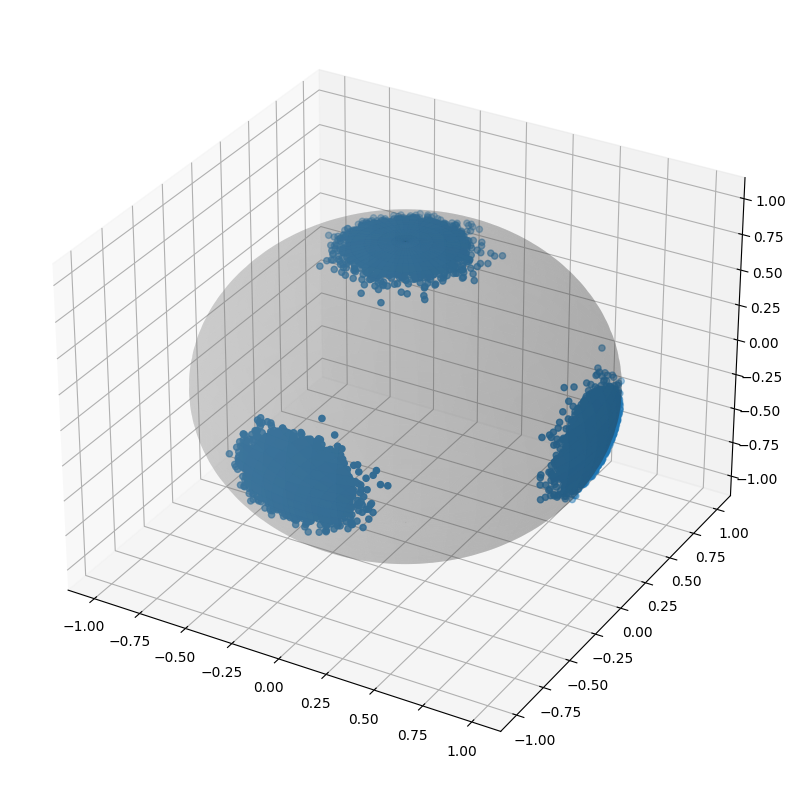

In [9]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax = sphere_plot(ax)
sample = torch.cat([item.unsqueeze(0) for item in x_0_tensor], dim=0)
ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])


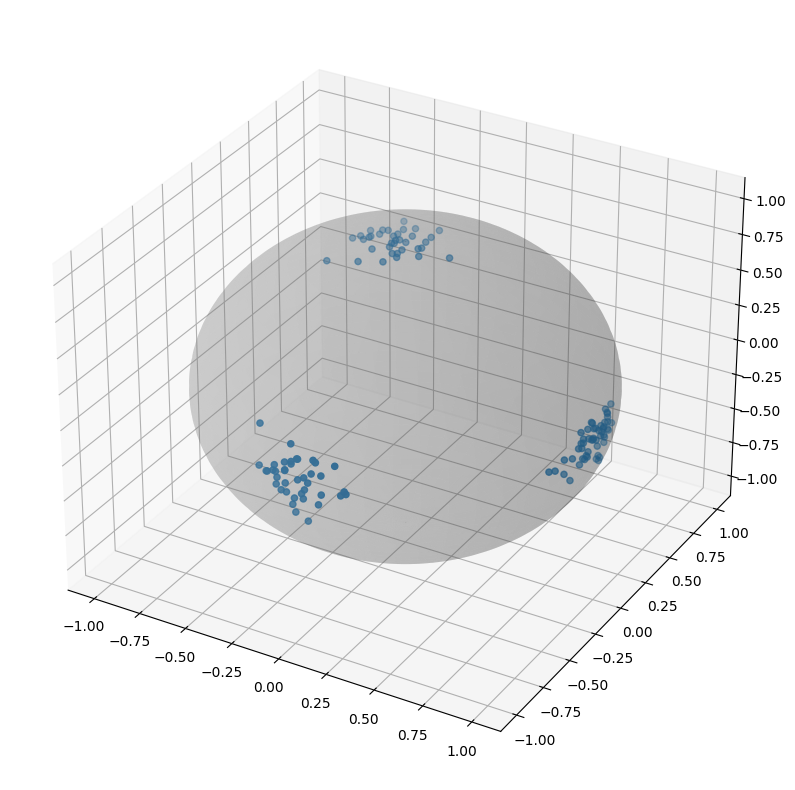

In [9]:

class vMFForwardDiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, x_0_tensor, t_batch_tensor, suff_stats_tensor):
        super().__init__()
        self.x_0_tensor = x_0_tensor
        self.t_batch_tensor = t_batch_tensor
        self.suff_stats_tensor = suff_stats_tensor
        
    def __len__(self):
        return self.x_0_tensor.shape[0]
        
    def __getitem__(self, idx):
        return self.x_0_tensor[idx], self.t_batch_tensor[idx], self.suff_stats_tensor[idx]
    
x_0_tensor, t_batch_tensor, suff_stats_tensor = torch.load('vMF_Mixture_x_0_dataset.pth'), torch.load('vMF_Mixture_t_batch_dataset.pth'), torch.load('vMF_Mixture_suff_stats_dataset.pth')

forward_diffusion_dataset = vMFForwardDiffusionDataset(x_0_tensor, t_batch_tensor, suff_stats_tensor)

forward_diffusion_dataloader = torch.utils.data.DataLoader(forward_diffusion_dataset, batch_size=128, shuffle=True)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax = sphere_plot(ax)
sample = next(iter(forward_diffusion_dataloader))[0]
ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

## Model

In [140]:
from models import PositionalEmbedding
import torch.nn as nn

class vMFModel(nn.Module):
    def __init__(self, hidden_dim=64, time_emb_hidden_dim=16):
        super().__init__()
        base_channels = 8
        self.time_mlp = nn.Sequential(
            PositionalEmbedding(base_channels, 1.0),
            nn.Linear(base_channels, hidden_dim),
            nn.SiLU()
        )
        self.mlp_1 = nn.Sequential(nn.Linear(3, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, hidden_dim), nn.GELU())
        self.mlp_2 = nn.Linear(hidden_dim, 3)
        
    def forward(self, x, t):
        time_emb = self.time_mlp(t)
        x = self.mlp_1(x)
        x = x + time_emb
        ret_val = self.mlp_2(x)
        ret_val = ret_val / torch.norm(ret_val, dim=1).reshape(-1, 1)
        return ret_val


## Training

In [10]:


def train_generated_dataset(model, opt, dataloader, max_iter=1000):
    pbar = tqdm(range(max_iter))
    model.train()
    loss_storage = []
    
    for i in pbar:
        x_0, t_batch, suff_stats = next(iter(dataloader))
        x_0, t_batch, suff_stats = x_0.to(device), t_batch.to(device), suff_stats.to(device)
        
        x_theta = model(suff_stats, t_batch)
        
        loss = KL(x_0, x_theta, t_batch).mean()
        
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        loss_storage.append(loss.detach().numpy())
        
        pbar.set_description(f'Iter {i} Loss: {loss.item():.4f}')
        if (i + 1) % 1000 == 0:
            torch.save(model.state_dict(), f'vMF_Mxiture_ssddpm_{i}_iter.pth')
    return loss_storage


In [21]:
model = vMFModel(hidden_dim=64, time_emb_hidden_dim=16).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [22]:

loss_storage = train_generated_dataset(model, opt, forward_diffusion_dataloader, max_iter=50000)


Iter 49999 Loss: 0.1453: 100%|███████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:37<00:00, 229.39it/s]


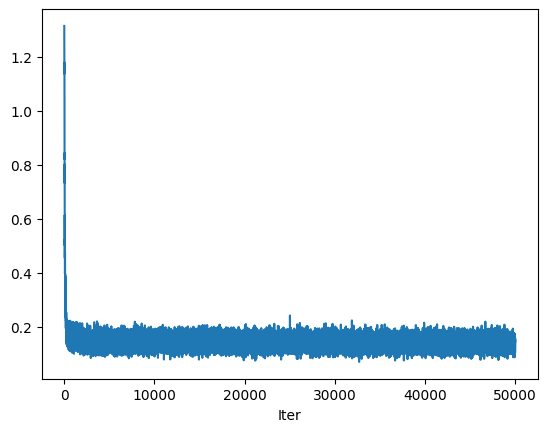

In [23]:
plt.plot(np.arange(len(loss_storage)), loss_storage, label='loss')
plt.xlabel('Iter')
plt.show()

## Generation

In [11]:


def generate_alpha_normed(model, filename='vMF_ssddpm_samples.png'):
    model.eval()
    batch_size = 4024
    
    x_T_dist = BatchedvMF(torch.Tensor([[0, 1, 0]]).to(device).repeat([batch_size, 1]), torch.Tensor([1e-4]).to(device).repeat(batch_size), device='cpu')
    x_t = x_T_dist.sample()
    
    suff_stats = sufficient_stats(x_t, torch.tensor([T], device=device).repeat(batch_size).reshape([-1, 1]))
    alphas = noising_sch(torch.tensor([T], device=device).repeat(batch_size))
    
    suff_stats_normed = suff_stats / alphas.reshape([-1, 1]).repeat([1, 3])
    
    samples_history = []
    x_0_samples_history = []
    for t in tqdm(range(T, 1, -1)):
        t_batch = torch.tensor([t], device=device).repeat(batch_size)
        x_0 = model(suff_stats_normed, t_batch)
        
        mu = noising_sch(t_batch)
        alphas += mu
        
        dist = get_dist(mu, x_0)
        x_t = dist.sample()
        
        x_0_samples_history.append(x_0.detach().cpu())
        samples_history.append(x_t)
        
        alphas += mu
        
        suff_stats += sufficient_stats(x_t, torch.tensor([t - 1], device=device).repeat(batch_size).reshape([-1, 1]))
        
        suff_stats_normed = suff_stats / alphas.reshape([-1, 1]).repeat([1, 3])
    
    t_batch = torch.tensor([1], device=device).repeat(batch_size)
    x_0 = model(suff_stats_normed, t_batch)
    
    return x_0, samples_history, x_0_samples_history


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:54<00:00,  1.82it/s]


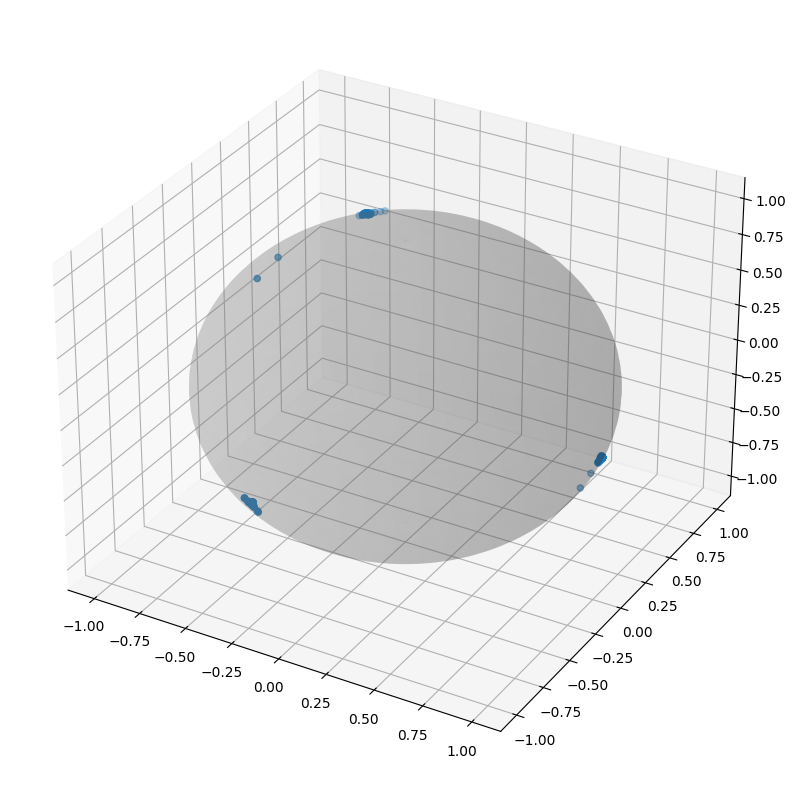

In [26]:
with torch.no_grad():
    x_0, samples_history, x_0_samples_history = generate_alpha_normed(model)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax = sphere_plot(ax)
sample = x_0.cpu().numpy()

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

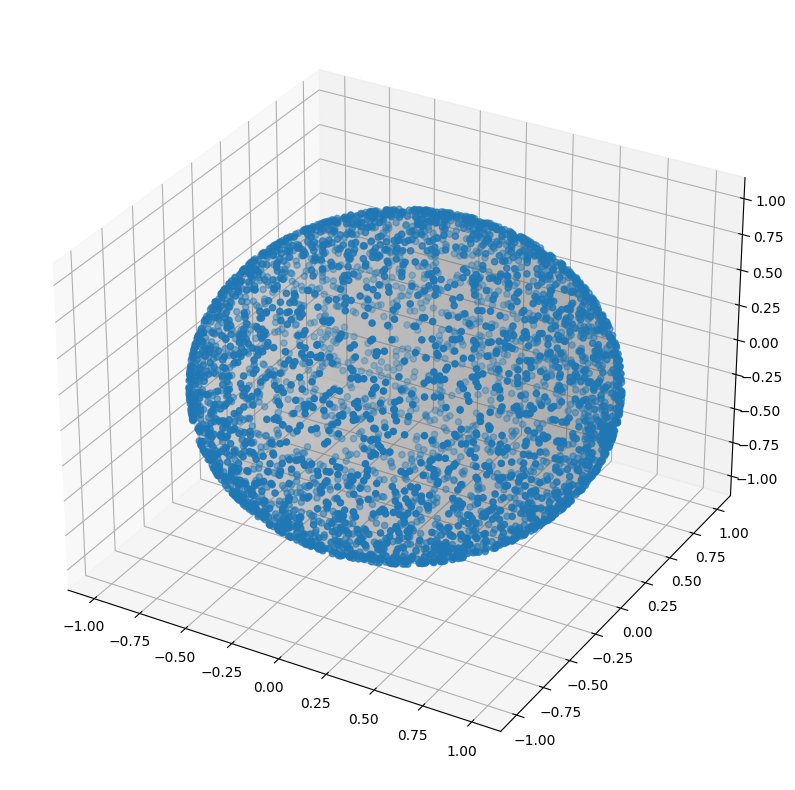

In [34]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax = sphere_plot(ax)
# sample = x_0.cpu().numpy()
sample = samples_history[-99].cpu().numpy()

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

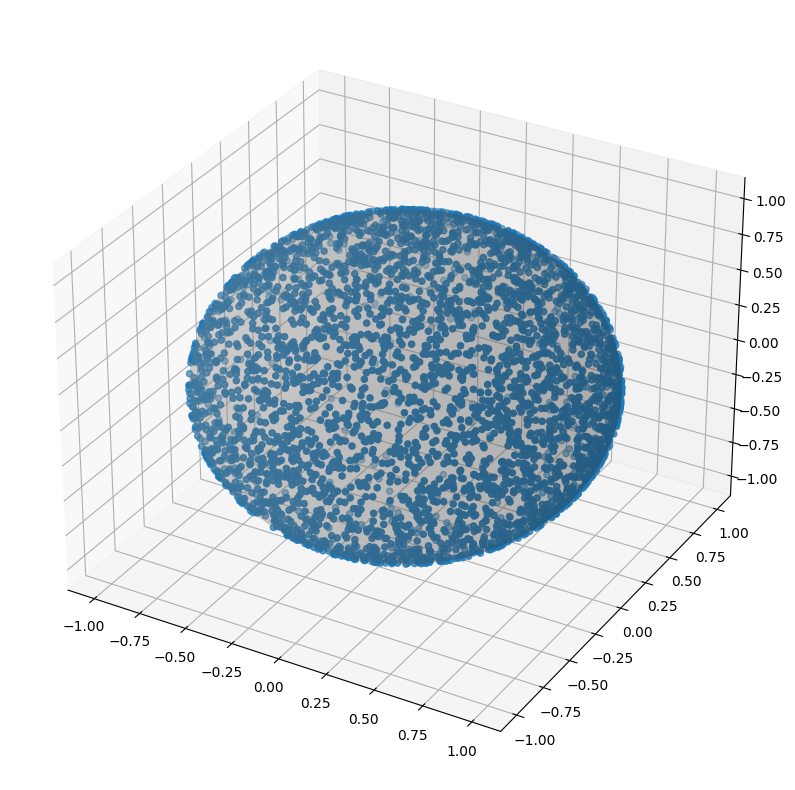

In [28]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax = sphere_plot(ax)
# sample = x_0.cpu().numpy()
sample = samples_history[-49].cpu().numpy()

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

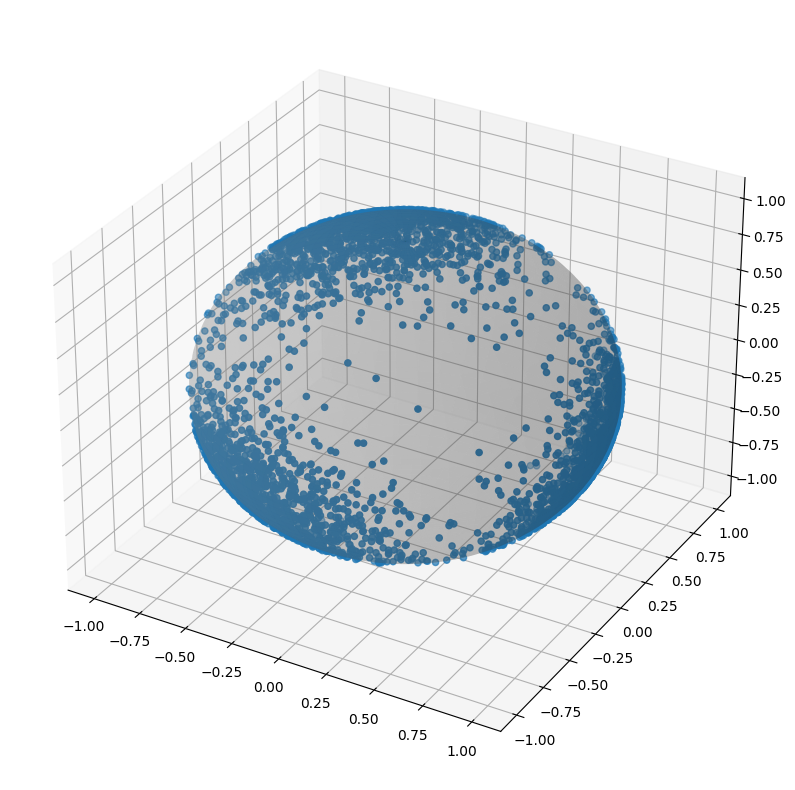

In [33]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax = sphere_plot(ax)
# sample = x_0.cpu().numpy()
sample = samples_history[-19].cpu().numpy()

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

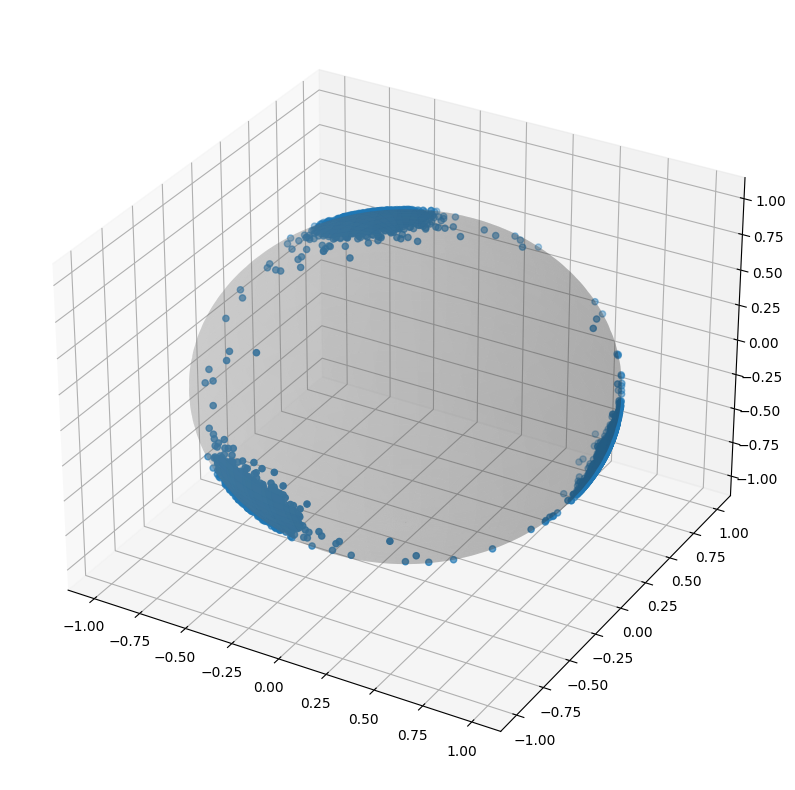

In [30]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax = sphere_plot(ax)
# sample = x_0.cpu().numpy()
sample = samples_history[-9].cpu().numpy()

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

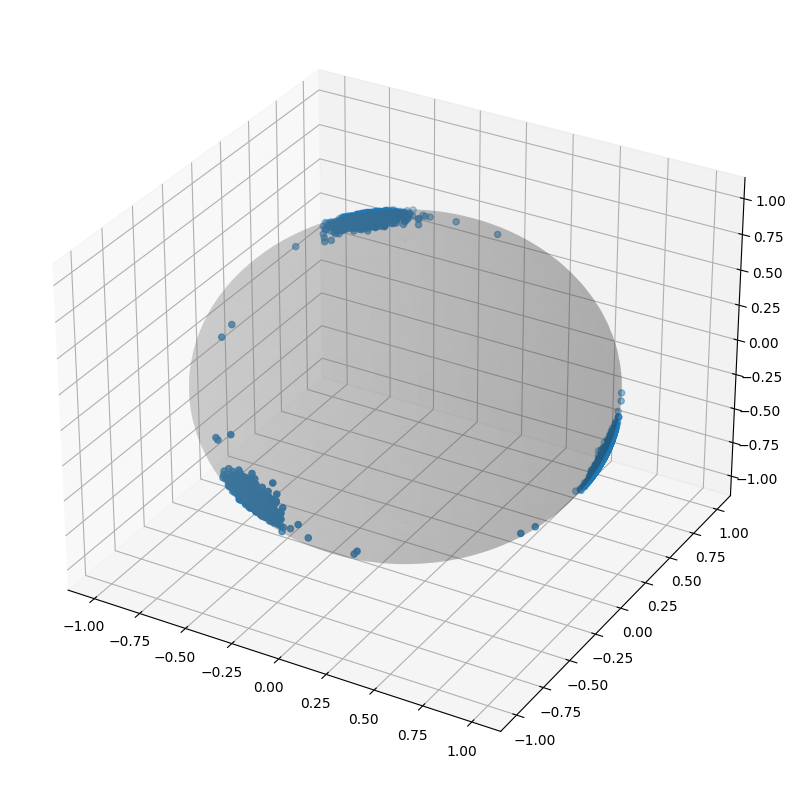

In [32]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax = sphere_plot(ax)
# sample = x_0.cpu().numpy()
sample = samples_history[-5].cpu().numpy()

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

## Visualization of Forward Diffusion

torch.Size([1024, 3])


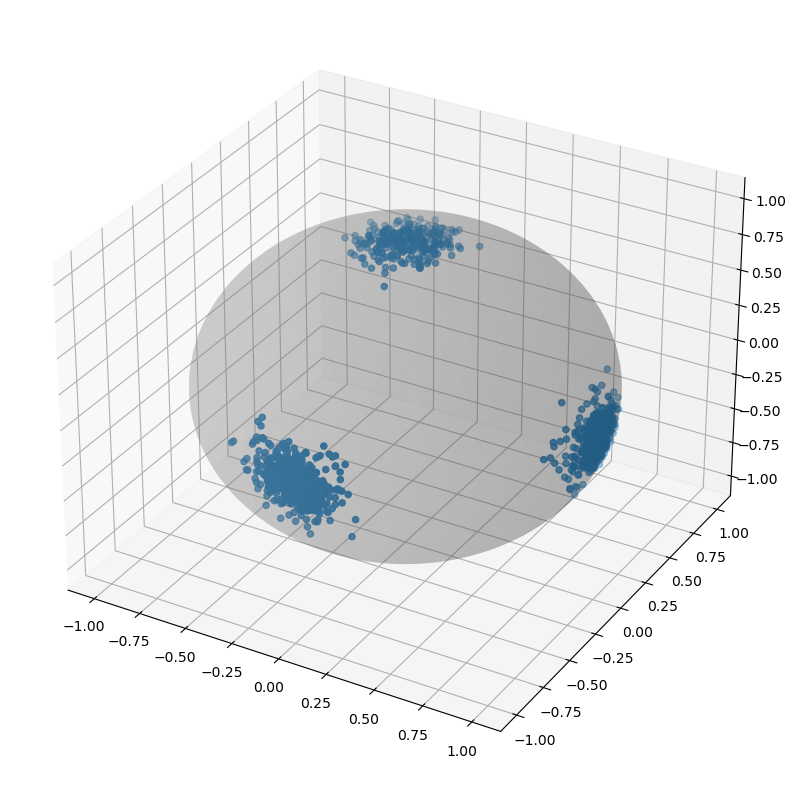

In [64]:
def visualize_forward_diffusion_vMF(t):
    batch_size = 1024
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection="3d")
    t_batch = torch.tensor([t], device='cpu').repeat(batch_size)
    mu = noising_sch(t_batch)
    
    vMF_Mixture_dataloader = torch.utils.data.DataLoader(vMF_Mixture, batch_size=batch_size, shuffle=True)

    vmf_mixture_samples = next(iter(vMF_Mixture_dataloader)) 
    
    dist = BatchedvMF(torch.Tensor(vmf_mixture_samples), mu, device='cpu')
    samples = dist.sample().cpu()

    ax = sphere_plot(ax)
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])
    plt.show()
        
visualize_forward_diffusion_vMF(0)


torch.Size([1024, 3])


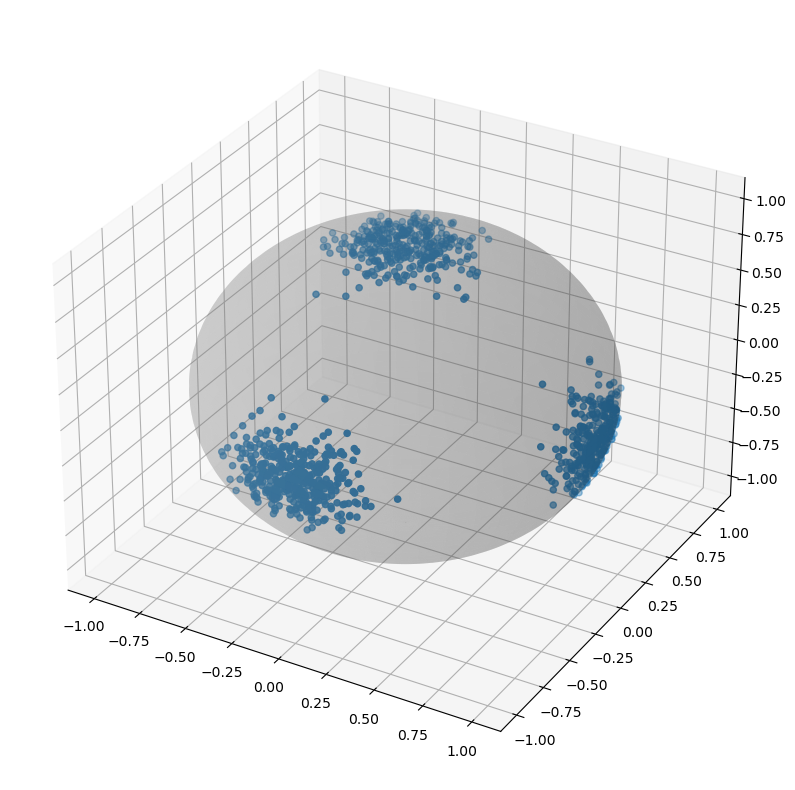

In [65]:
visualize_forward_diffusion_vMF(10)

torch.Size([1024, 3])


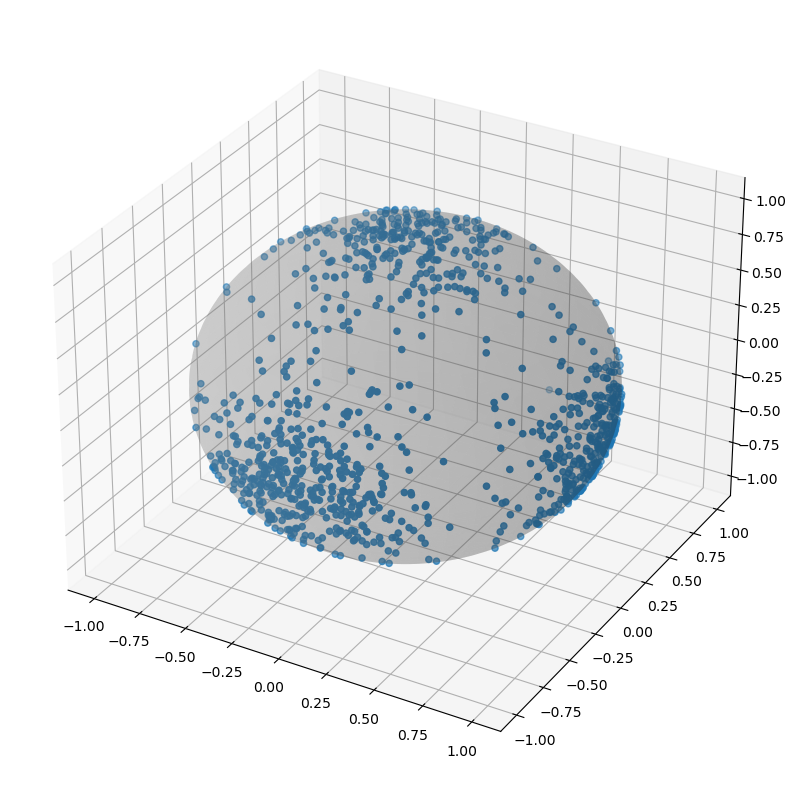

In [66]:
visualize_forward_diffusion_vMF(20)

torch.Size([1024, 3])


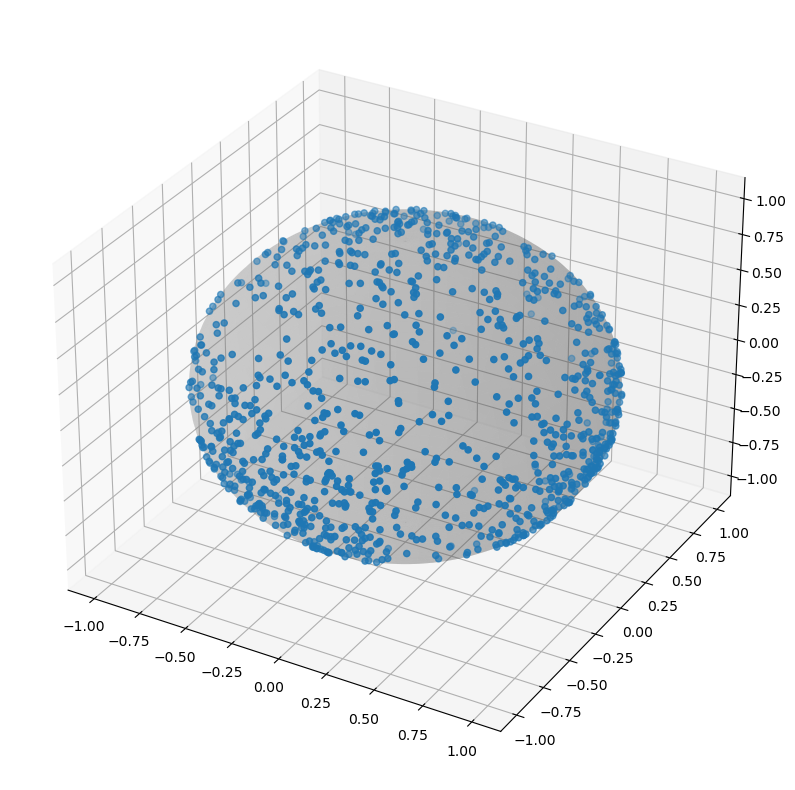

In [71]:
visualize_forward_diffusion_vMF(30)

torch.Size([1024, 3])


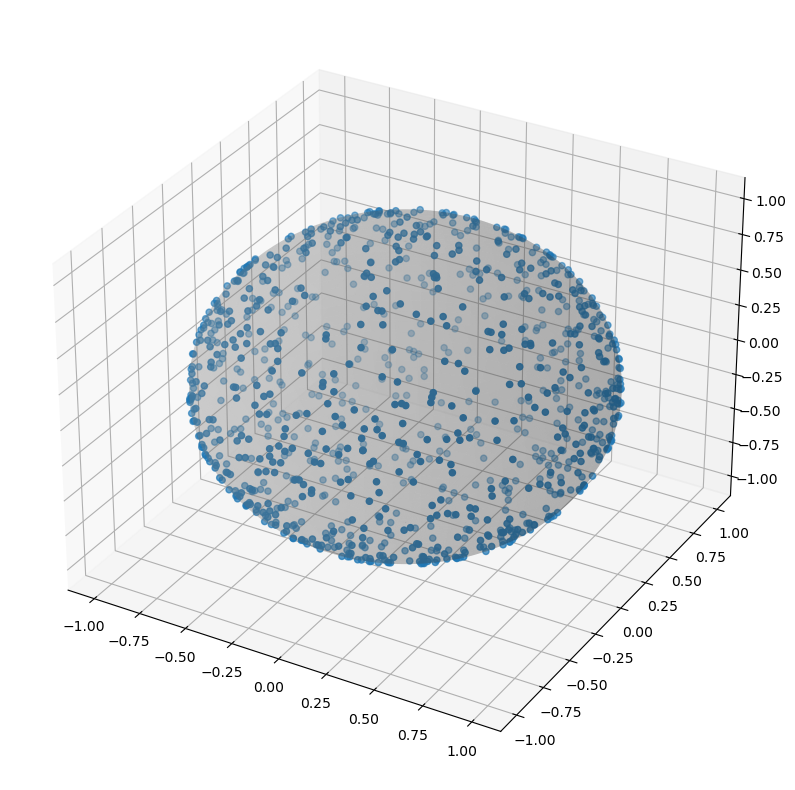

In [69]:
visualize_forward_diffusion_vMF(100)

In [13]:

import pandas as pd
from torch.utils.data import Dataset, DataLoader

class FireDataset(Dataset):
    
    def __init__(self):
        self.data = pd.read_csv('fire.csv')

        self.data['lat'] = self.data.index
        self.data['long'] = self.data['# https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/active-fire-data']

        self.lons = self.data['long'].values
        self.lats = self.data['lat'].values
        
        
    def __getitem__(self, idx):
        lon = np.pi * torch.tensor([self.lons[idx]], dtype=torch.float32) / 180.
        lat = np.pi * torch.tensor([self.lats[idx]], dtype=torch.float32) / 180.
        x = torch.cat([
            torch.cos(lat) * torch.cos(lon),
            torch.cos(lat) * torch.sin(lon),
            torch.sin(lat)
        ])
        return x
    
    def __len__(self):
        return self.data.shape[0]
    
fire_dataset = FireDataset()

sphere_dataloader = torch.utils.data.DataLoader(fire_dataset, batch_size=100, shuffle=True)
next(iter(sphere_dataloader))

tensor([[ 0.4805, -0.7839, -0.3932],
        [ 0.5385,  0.4701,  0.6993],
        [ 0.4068, -0.9084,  0.0966],
        [ 0.3668, -0.9174,  0.1546],
        [ 0.9821, -0.1131,  0.1505],
        [-0.6303,  0.7112, -0.3113],
        [ 0.8712,  0.4859,  0.0698],
        [ 0.3624, -0.9249,  0.1149],
        [ 0.9832,  0.1091,  0.1460],
        [ 0.9510,  0.2997, -0.0759],
        [-0.0794, -0.7729,  0.6296],
        [ 0.5018,  0.4478,  0.7401],
        [ 0.4388, -0.8828,  0.1677],
        [ 0.5015, -0.7918, -0.3486],
        [-0.0026, -0.9446,  0.3281],
        [ 0.9785, -0.0797,  0.1903],
        [ 0.9568,  0.2839, -0.0626],
        [ 0.4909, -0.7407, -0.4587],
        [ 0.7823,  0.5828,  0.2198],
        [ 0.7462,  0.4283, -0.5096],
        [-0.2740,  0.9245,  0.2649],
        [ 0.3529, -0.9273,  0.1249],
        [ 0.5219,  0.5135,  0.6811],
        [ 0.9073,  0.4103,  0.0915],
        [ 0.2323, -0.7494, -0.6201],
        [ 0.8808,  0.4712,  0.0468],
        [ 0.1637,  0.9361,  0.3112],
 

## Generate Fire Forward diffusion dataset

In [15]:
import math
import torch.nn as nn

from einops import rearrange, repeat

class SinusoidalPosEmb(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=x.device) * -emb)
        emb = rearrange(x, 'i -> i 1') * rearrange(emb, 'j -> 1 j')
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

class MLP(nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels, time_embed_dim, num_hidden_blocks):
        super().__init__()
        self.to_time_embed = SinusoidalPosEmb(time_embed_dim)
        self.in_layer = nn.Sequential(
            nn.Linear(in_channels + time_embed_dim, hidden_channels),
            nn.SiLU()
        )
        self.hidden_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.SiLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.SiLU(),
            ) for _ in range(num_hidden_blocks)
        ])
        self.out_layer = nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, time):
        time_embed = self.to_time_embed(time)
        x = self.in_layer(torch.cat([x, time_embed], dim=-1))
        for hidden_block in self.hidden_blocks:
            x = hidden_block(x) + x
        x = self.out_layer(x)
        
        return x / torch.norm(x, dim=1).reshape(-1, 1)

In [17]:
fire_dataset = FireDataset()
fire_dataloader = torch.utils.data.DataLoader(fire_dataset, batch_size=100, shuffle=True)

batch_size = 64
n_samples = batch_size * 3 * 400

x_0_tensor, t_batch_tensor, suff_stats_tensor = generate_dataset(fire_dataset, n_samples, batch_size=batch_size)

torch.save(x_0_tensor, 'fire_x_0_dataset.pth')
torch.save(t_batch_tensor, 'fire_t_batch_dataset.pth')
torch.save(suff_stats_tensor, 'fire_suff_stats_dataset.pth')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [19:22<00:00,  1.03it/s]


In [18]:
   
x_0_tensor, t_batch_tensor, suff_stats_tensor = torch.load('fire_x_0_dataset.pth'), torch.load('fire_t_batch_dataset.pth'), torch.load('fire_suff_stats_dataset.pth')

forward_diffusion_dataset = vMFForwardDiffusionDataset(x_0_tensor, t_batch_tensor, suff_stats_tensor)

forward_diffusion_dataloader = torch.utils.data.DataLoader(forward_diffusion_dataset, batch_size=128, shuffle=True)


In [20]:

# model = vMFModel(hidden_dim=256, time_emb_hidden_dim=16).to(device)
model = MLP(3, 3, 512, 12, 2)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4)


In [ ]:
loss_storage = train_generated_dataset(model, opt, forward_diffusion_dataloader, max_iter=500000)


Iter 2543 Loss: 0.1401:   1%|▍                                                                                | 2540/500000 [00:43<2:20:47, 58.89it/s]

In [174]:
with torch.no_grad():
    x_0, samples_history, x_0_samples_history = generate_alpha_normed(model)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax = sphere_plot(ax)
samples = x_0.cpu().numpy()

ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])

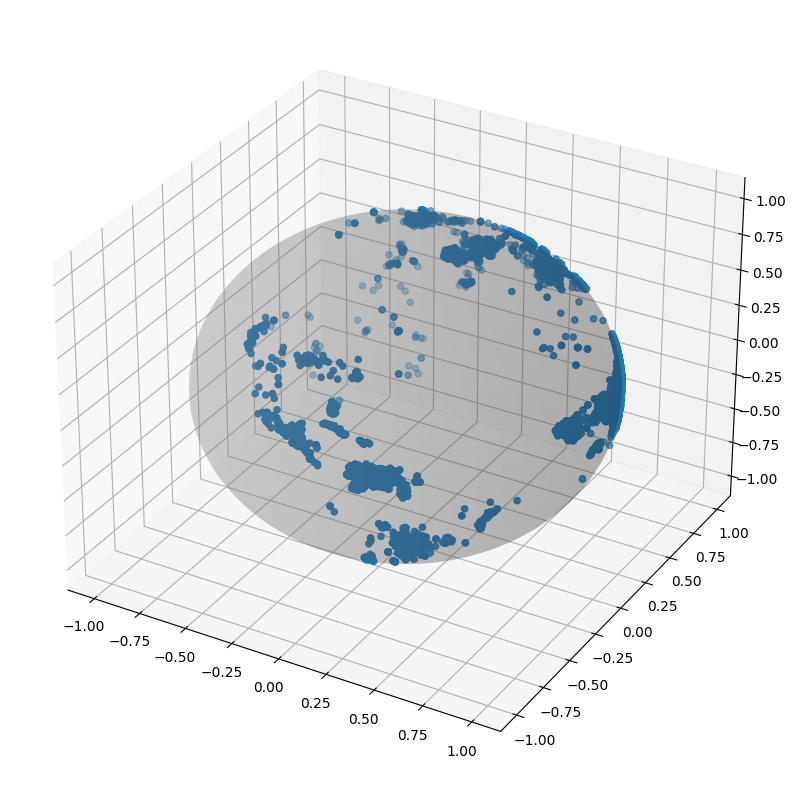

In [118]:
batch_size = 1024
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection="3d")

samples = next(iter(sphere_dataloader))

# dist = BatchedvMF(torch.Tensor(vmf_mixture_samples), mu, device='cpu')
# samples = dist.sample().cpu()

ax = sphere_plot(ax)
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])
plt.show()


In [74]:
!pip install --upgrade "jax[cpu]"

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.6 MB/s eta 0:00:00 MB/s eta 0:00:01:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.9 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 MB 4.0 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for jax: filename=jax-0.4.11-py3-none-any.whl size=1487877 sha256=db173829b678393390b2dd8c810680ffe2361200625701b4663fddd97453dee6
  Stored in directory: /home/skholkin/.cache/pip/wheels/24/d2/da/9e8cec7afad3784f022c4dd1184ba33f9220a9d24b712e50eb
Successfully built jax


/tmp/ipykernel_10319/2051995851.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  cax = ax.scatter(x, y, z, s=50, vmin=0.0, vmax=2.0, c=c, cmap=cmap)


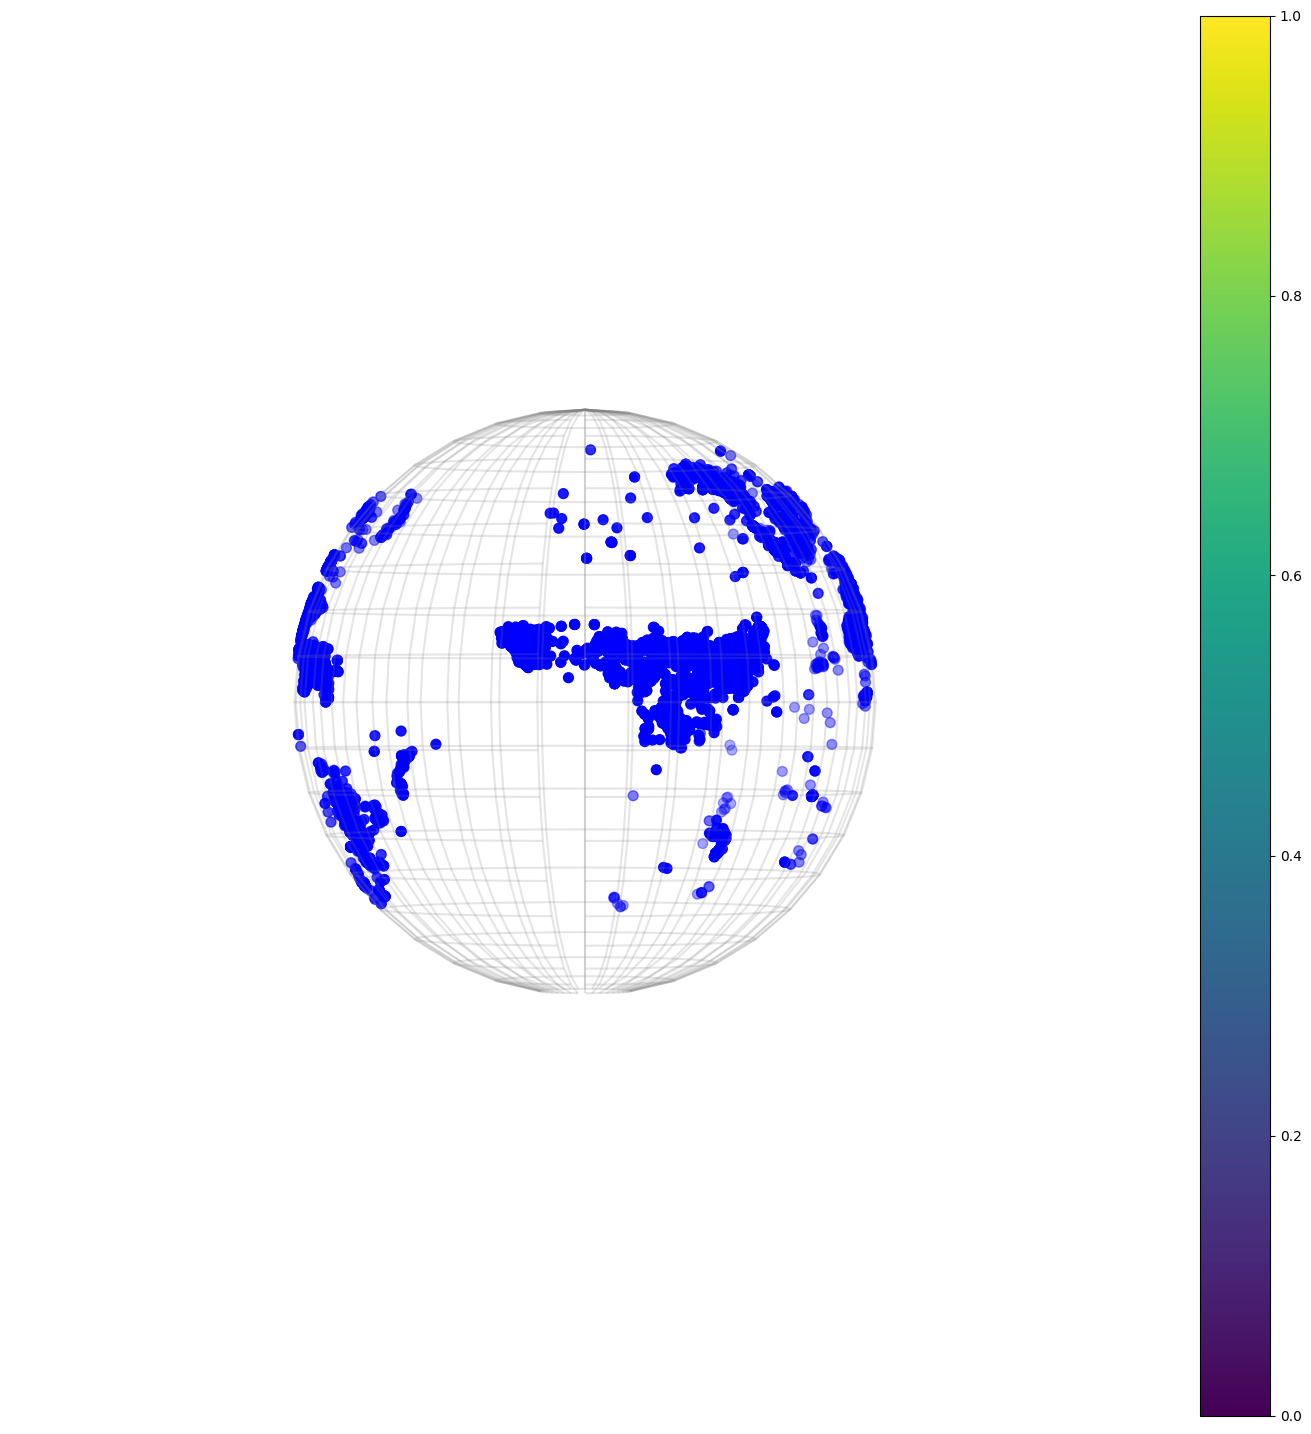

In [119]:
# visualization from riemannian sde

import seaborn as sns
import geomstats.visualization as visualization

def remove_background(ax):
    ax.set_axis_off()
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    return ax

# x0 None
# xt points
# size = 10
def plot_3d(x0, xt, size, prob=None):
    fig = plt.figure(figsize=(size, size))
    ax = fig.add_subplot(111, projection="3d")
    ax = remove_background(ax)
    fig.subplots_adjust(left=-0.2, bottom=-0.2, right=1.2, top=1.2, wspace=0, hspace=0)
    # ax.view_init(elev=30, azim=45)
    ax.view_init(elev=0, azim=0)
    cmap = sns.cubehelix_palette(as_cmap=True)
    sphere = visualization.Sphere()
    sphere.draw(ax, color="red", marker=".")
    # sphere_plot(ax)
    # sphere.plot_heatmap(ax, pdf, n_points=16000, alpha=0.2, cmap=cmap)
    if x0 is not None:
        cax = ax.scatter(x0[:, 0], x0[:, 1], x0[:, 2], s=50, color="green")
    if xt is not None:
        x, y, z = xt[:, 0], xt[:, 1], xt[:, 2]
        c = prob(xt) if prob is not None else "blue"
        cax = ax.scatter(x, y, z, s=50, vmin=0.0, vmax=2.0, c=c, cmap=cmap)
        
    # if grad is not None:
    #     u, v, w = grad[:, 0], grad[:, 1], grad[:, 2]
    #     quiver = ax.quiver(
    #         x, y, z, u, v, w, length=0.2, lw=2, normalize=False, cmap=cmap
    #     )
    #     quiver.set_array(c)
    
    plt.colorbar(cax)
    # plt.savefig(out, dpi=dpi, bbox_inches="tight", transparent=True)
#     plt.close(fig)
    return fig


fig = plot_3d(None, samples, 10)
plt.show()

In [23]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 758.2 kB/s eta 0:00:001m745.7 kB/s eta 0:00:01


In [43]:
pd.read_csv('flood.csv').iloc[0]

# http://floodobservatory.colorado.edu/Archives/index.html    long
Name: lat, dtype: object

In [44]:
pd.read_csv('flood.csv').head()

# http://floodobservatory.colorado.edu/Archives/index.html
lat                                                    long        
35.8142                                             5.23026        
-18.7111                                           -45.3489        
10.0207                                             122.974        
1.01489                                             124.606

In [59]:
data['lat'].values

array([-25.088, -30.087,  -6.37 , ...,  -6.623,  -7.276,  -7.428])

In [55]:
data = pd.read_csv('fire.csv')
data['lat'] = data.index
data['long'] = data['# https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/active-fire-data']

In [175]:

from mpl_toolkits.basemap import Basemap

def x2angle(x):
    x = x / torch.norm(x, dim=-1, keepdim=True)
    angle = torch.zeros(*x.shape[:-1], 2)
    angle[..., 0] = torch.atan2(x[..., 1], x[..., 0])
    angle[..., 1] = torch.arcsin(x[..., 2])
    return angle

def plot_images(samples, fig_name='visualization_fire.png'):
    gen_coords = samples
    lon_coords = 180. * x2angle(gen_coords)[:, 0].cpu() / np.pi
    lat_coords = 180. * x2angle(gen_coords)[:, 1].cpu() / np.pi
    disaster_data = pd.read_csv('fire.csv')
    
    disaster_data['lat'] = disaster_data.index
    disaster_data['long'] = disaster_data['# https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/active-fire-data']
    
    lons = torch.tensor(np.pi * disaster_data['long'].values / 180.)
    lats = torch.tensor(np.pi * disaster_data['lat'].values / 180.)
    basemap = Basemap(projection='robin', lat_0=0, lon_0=0)

    plt.figure(figsize=(16, 8))
    basemap.drawcoastlines()
    x, y = basemap(180. * lons.numpy() / np.pi, 180. * lats.numpy() / np.pi)
    basemap.hexbin(x, y, gridsize=(30, 30), vmax=100, extent=(0, basemap.urcrnrx, 0, basemap.urcrnry))

    plt.figure(figsize=(16, 8))
    basemap.drawcoastlines()
    x, y = basemap(lon_coords.numpy(), lat_coords.numpy())
    basemap.hexbin(x, y, gridsize=(30, 30), vmax=100, extent=(0, basemap.urcrnrx, 0, basemap.urcrnry))

    plt.savefig(fig_name)
    
    plt.show()
    plt.figure(figsize=(16, 8))
    x, y = basemap(180. * lons.numpy() / np.pi, 180. * lats.numpy() / np.pi)
    plt.scatter(180. * lons.numpy() / np.pi, 180. * lats.numpy() / np.pi, s=0.1)

    plt.figure(figsize=(16, 8))
    plt.scatter(lon_coords.numpy(), lat_coords.numpy(), s=0.1)

    plt.show()
    
plot_images(torch.Tensor(samples))
